### imports 

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import seaborn as sns
import math
# %matplotlib inline
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor


### read data 

In [2]:
lo={'recommendation_set_id':str, 'user_id':str, 'session_id':str, 'query_identifier':str,
'query_word_count':float, 'query_char_count':float, 'query_detected_language':str,
'query_document_id':str, 'document_language_provided':str, 'year_published':float,
'number_of_authors':float, 'abstract_word_count':float, 'abstract_char_count':float,
'abstract_detected_language':str, 'first_author_id':str,
'num_pubs_by_first_author':float, 'organization_id':str, 'application_type':str,
'item_type':str, 'request_received':str, 'hour_request_received':str,
'response_delivered':str, 'rec_processing_time':float, 'app_version':str, 'app_lang':str,
'user_os':str, 'user_os_version':str, 'user_java_version':str, 'user_timezone':str,
'country_by_ip':str, 'timezone_by_ip':str, 'local_time_of_request':str,
'local_hour_of_request':str, 'number_of_recs_in_set':float,
'recommendation_algorithm_id_used':str, 'algorithm_class':str, 'cbf_parser':str,
'search_title':str, 'search_keywords':str, 'search_abstract':str,
'time_recs_recieved':str, 'time_recs_displayed':str, 'time_recs_viewed':str,
'clicks':float, 'ctr':float,'set_clicked':float
   }
pars=['request_received', 'response_delivered','local_time_of_request','time_recs_recieved','time_recs_displayed','time_recs_viewed']


In [3]:
df_w=pd.read_csv('tcdml1920-rec-click-pred--training.csv',na_values=["\\N","nA"], dtype=lo, parse_dates=pars)

In [4]:
df_kag=pd.read_csv('tcdml1920-rec-click-pred--test.csv',na_values=["\\N","nA"], dtype=lo, parse_dates=pars)

### cleaning jabref 

In [5]:
# global dict_key
# dict_key={}
def process(df,run,dict_key):
#     global dict_key
#     dict_key={}
    
    df=df[df.organization_id=='1']
    df=df[['query_word_count','query_char_count', 'query_detected_language', 'query_document_id','year_published',
           'number_of_authors','abstract_word_count', 'abstract_char_count','first_author_id','num_pubs_by_first_author',
           'request_received','hour_request_received','rec_processing_time','app_version', 'app_lang','user_os','user_timezone','country_by_ip',
           'timezone_by_ip','local_hour_of_request','recommendation_algorithm_id_used', 'algorithm_class', 'cbf_parser',
           'search_title', 'search_keywords','search_abstract','clicks','set_clicked']]


    # query_word_count
    # query_char_count
    # query_detected_language
    df['query_detected_language'].fillna(df['query_detected_language'].mode()[0], inplace=True)


    # query_document_id
    df['query_doc_id_present']=df.query_document_id.isna()*1
    df.drop(columns='query_document_id',inplace=True)

    # year_published

    df.drop(df[df.year_published >2019].index, inplace=True)
    # df['yr']=df.year_published.map(lambda x: '1950' if x<1950 else '1950-1980' if x<1980 else '1980-2000' if x<2000 else '2000-2010' if x<2010 else '2010-2019' if x<2019 else 0)
    # df.groupby('yr').set_clicked.mean()
    # df.drop(columns='yr',inplace=True)
#     df.year_published.fillna(df.year_published.min(),inplace=True) # because pos correlation between year and clicks

    # number_of_authors
#     df.number_of_authors.fillna(10,inplace=True) #nulls have same mean of set_clicked as 10 authors

    # abstract_word_count
#     df.abstract_word_count.fillna(df.abstract_word_count.median(),inplace=True)
    # abstract_char_count
#     df.abstract_char_count.fillna(df.abstract_char_count.median(),inplace=True)

# first_author_id

#     df['first_author_id']=df['first_author_id'].astype(str)
    
    # num_pubs_by_first_author
#     df.num_pubs_by_first_author.fillna(df.local_hour_of_request.median(),inplace=True) 

    # request_received

#     df['request_received']=df['request_received'].astype('datetime64[D]')
    df['day_of_week'] = df['request_received'].dt.day_name()
    df['month'] = df['request_received'].dt.month
    df['year']=df['request_received'].dt.year
    df['month']=df.month.astype(str)
    df.drop(columns=['request_received'],inplace=True)

    # hour_request_received
#     df['xhr_req_recvd'] = df.hour_request_received.map(lambda x:math.sin(2*math.pi*x/24))
#     df['yhr_req_recvd']  = df.hour_request_received.map(lambda x:math.cos(2*math.pi*x/24))
#     df.drop(columns='hour_request_received',inplace=True)
    
#     rec_processing_time
    if run=='train':
        df=df[df.rec_processing_time<25]
    
    df.drop(columns=['rec_processing_time'],inplace=True)



    # app_version
    df['app_version'].fillna(df['app_version'].mode()[0], inplace=True)

#     app_lang
    df['app_lang'].fillna(df['app_lang'].mode()[0], inplace=True)

    # user_os
    # df[(df.user_os.isna()==False)&(df.user_os!='Not provided')].groupby('user_os').set_clicked.sum()
#     df['user_os_linux']=df.user_os.map(lambda x: 1 if x=='Linux' else 0)
#     df['user_os_Mac_OS_X']=df.user_os.map(lambda x: 1 if x=='Mac OS X' else 0)
#     df['user_os_Not_provided']=df.user_os.map(lambda x: 1 if x=='Not provided' else 0)
#     df['user_os_Windows_10']=df.user_os.map(lambda x: 1 if x=='Windows 10' else 0)
#     df['user_os_Windows_7']=df.user_os.map(lambda x: 1 if x=='Windows 7' else 0)
    df['user_os_Windows_8_1']=df.user_os.map(lambda x: 1 if x=='Windows 8.1' else 0)
    df['user_os_provided']=df.user_os.map(lambda x: 1 if x else 0)
    df.drop(columns='user_os',inplace=True)


    #     user_timezone
    df['user_timezone_present']=df.user_timezone.map(lambda x:1 if x else 0)
    df['user_timezone_aus']=df.user_timezone.map(lambda x:1 if x=='Australia/Sydney' else 0)
    df.drop(columns='user_timezone',inplace=True)

    # country_by_ip
#     df['country_by_ip'].fillna(df['country_by_ip'].mode()[0], inplace=True) #do after 'other' thingy 

#     timezone_by_ip
    # local_hour_of_request
    df.local_hour_of_request.fillna(df.local_hour_of_request.mode()[0],inplace=True) 
#     df['xhr_local_req_recvd'] = df.local_hour_of_request.map(lambda x:math.sin(2*math.pi*x/24))
#     df['yhr_local_req_recvd']  = df.local_hour_of_request.map(lambda x:math.cos(2*math.pi*x/24))
#     df.drop(columns='local_hour_of_request',inplace=True)

    # recommendation_algorithm_id_used
#     df['recommendation_algorithm_id_used']=df['recommendation_algorithm_id_used'].astype(str)
    df['recommendation_algorithm_id_used'].fillna(df['recommendation_algorithm_id_used'].mode()[0], inplace=True)

    # algorithm_class
    # cbf_parser
    df['cbf_standard_QP']=df.cbf_parser.map(lambda x:1 if x=='standard_QP' else 0)
    df['cbf_edismax_QP']=df.cbf_parser.map(lambda x:1 if x=='cbf_edismax_QP' else 0)
    df['cbf_mlt_QP']=df.cbf_parser.map(lambda x:1 if x=='cbf_mlt_QP' else 0)
    df['cbf_parser_used']=df.cbf_parser.map(lambda x: 1 if x else 0)
    df.drop(columns=['cbf_parser'],inplace=True)

    # search_title
    # search_keywords
    # set_clicked

    
    def convert_sparse_values(df, cols, threshold, replacement='other'):
        for col in [cols]:
            counts = df[col].value_counts()
            to_convert = counts[counts <= threshold].index.values
            dict_key[cols]=to_convert
            df[col] = df[col].replace(to_convert, replacement)

                
    if run=='train':
        convert_sparse_values(df,cols='query_detected_language', threshold=1000)
        convert_sparse_values(df,cols='app_lang', threshold=500)
        convert_sparse_values(df,cols='country_by_ip', threshold=150)
        convert_sparse_values(df,cols='timezone_by_ip', threshold=500)
        convert_sparse_values(df,cols='app_version', threshold=800)

    else:
        df['query_detected_language']=df.query_detected_language.map(lambda x: x if x in dict_key['query_detected_language'] else 'others')
        df['app_lang']=df.app_lang.map(lambda x: x if x in dict_key['app_lang'] else 'others')
        df['country_by_ip']=df.country_by_ip.map(lambda x: x if x in dict_key['country_by_ip'] else 'others')
        df['timezone_by_ip']=df.timezone_by_ip.map(lambda x: x if x in dict_key['country_by_ip'] else 'others')
        df['app_version']=df.app_version.map(lambda x: x if x in dict_key['app_version'] else 'others')
        
    df['country_by_ip'].fillna(df['country_by_ip'].mode()[0], inplace=True)
    df.timezone_by_ip.fillna(df.timezone_by_ip.mode()[0],inplace=True) 

#     df.drop(columns=['year_published','number_of_authors','abstract_word_count', 'abstract_char_count',
#                     'first_author_id','num_pubs_by_first_author'],inplace=True)
    
    df=df.drop(columns=['clicks','set_clicked']).merge(df[['clicks','set_clicked']], 
                                    on=df[['clicks','set_clicked']].index).drop(columns='key_0')
    
    return df,dict_key

In [6]:
df_w_p,d=process(df_w,run='train',dict_key={}) #train

df_kag_p,d=process(df_kag,run='test',dict_key=d) #kaggle


### category encodering 

In [7]:
def encode_all(df,encoder_to_use,handle_missing='return_nan'):  #handle_missing='value'/'return_nan'
    encoders_used={}
    for col in encoder_to_use:
        encoders_used[col]={}

        if encoder_to_use[col]['name']=='BackwardDifferenceEncoder':
            encoder=ce.BackwardDifferenceEncoder(cols=[col],return_df=1,drop_invariant=1,handle_missing=handle_missing)
            encoder.fit(X=df,y=df['set_clicked'])
            df=encoder.transform(df)
            encoders_used[col]['encoder_type']='BackwardDifferenceEncoder'
            encoders_used[col]['encoder_object']=encoder

        if encoder_to_use[col]['name']=='BaseNEncoder':
            encoder=ce.BaseNEncoder(cols=[col],return_df=1,drop_invariant=1,handle_missing=handle_missing,base=encoder_to_use[col]['base']) 
            encoder.fit(X=df,y=df['set_clicked'])
            df=encoder.transform(df)
            encoders_used[col]['encoder_type']='BackwardDifferenceEncoder'
            encoders_used[col]['encoder_object']=encoder

        if encoder_to_use[col]['name']=='BinaryEncoder':
            encoder=ce.BinaryEncoder(cols=[col],return_df=1,drop_invariant=1,handle_missing=handle_missing)
            encoder.fit(X=df,y=df['set_clicked'])
            df=encoder.transform(df)
            encoders_used[col]['encoder_type']='BackwardDifferenceEncoder'
            encoders_used[col]['encoder_object']=encoder

        if encoder_to_use[col]['name']=='CatBoostEncoder':
            encoder=ce.CatBoostEncoder(cols=[col],return_df=1,drop_invariant=1,handle_missing=handle_missing,sigma=encoder_to_use[col]['sigma'],a=encoder_to_use[col]['a'])
            encoder.fit(X=df,y=df['set_clicked'])
            df=encoder.transform(df)
            encoders_used[col]['encoder_type']='BackwardDifferenceEncoder'
            encoders_used[col]['encoder_object']=encoder

    #     if encoder_to_use[col]['name']=='HashingEncoder':
    #         encoder=ce.HashingEncoder(cols=[col],return_df=1,drop_invariant=1,handle_missing=handle_missing)
    #         encoder.fit(X=df,y=df['set_clicked'])
    #         df=encoder.transform(df)
    #         encoders_used[col]['encoder_type']='BackwardDifferenceEncoder'
#             encoders_used[col]['encoder_object']=encoder

        if encoder_to_use[col]['name']=='HelmertEncoder':
            encoder=ce.HelmertEncoder(cols=[col],return_df=1,drop_invariant=1,handle_missing=handle_missing)
            encoder.fit(X=df,y=df['set_clicked'])
            df=encoder.transform(df)
            encoders_used[col]['encoder_type']='BackwardDifferenceEncoder'
            encoders_used[col]['encoder_object']=encoder

        if encoder_to_use[col]['name']=='JamesSteinEncoder':
            encoder=ce.JamesSteinEncoder(cols=[col],return_df=1,drop_invariant=1,handle_missing=handle_missing, model=encoder_to_use[col]['model'])
            encoder.fit(X=df,y=df['set_clicked'])
            df=encoder.transform(df)
            encoders_used[col]['encoder_type']='BackwardDifferenceEncoder'
            encoders_used[col]['encoder_object']=encoder

        if encoder_to_use[col]['name']=='LeaveOneOutEncoder':
            encoder=ce.LeaveOneOutEncoder(cols=[col],return_df=1,drop_invariant=1,handle_missing=handle_missing,sigma=encoder_to_use[col]['sigma'])
            encoder.fit(X=df,y=df['set_clicked'])
            df=encoder.transform(df)
            encoders_used[col]['encoder_type']='BackwardDifferenceEncoder' 
            encoders_used[col]['encoder_object']=encoder

        if encoder_to_use[col]['name']=='MEstimateEncoder':
            encoder=ce.MEstimateEncoder(cols=[col],return_df=1,drop_invariant=1,handle_missing=handle_missing,randomized=encoder_to_use[col]['randomized'],sigma=encoder_to_use[col]['sigma'],m=encoder_to_use[col]['m'])
            encoder.fit(X=df,y=df['set_clicked'])
            df=encoder.transform(df)
            encoders_used[col]['encoder_type']='BackwardDifferenceEncoder' 
            encoders_used[col]['encoder_object']=encoder

        if encoder_to_use[col]['name']=='OneHotEncoder':
            encoder=ce.OneHotEncoder(cols=[col],return_df=1,drop_invariant=1,handle_missing=handle_missing,use_cat_names=True)
            encoder.fit(X=df,y=df['set_clicked'])
            df=encoder.transform(df)
            encoders_used[col]['encoder_type']='BackwardDifferenceEncoder'
            encoders_used[col]['encoder_object']=encoder

        if encoder_to_use[col]['name']=='OrdinalEncoder':
            encoder=ce.OrdinalEncoder(cols=[col],return_df=1,drop_invariant=1,handle_missing=handle_missing)
            encoder.fit(X=df,y=df['set_clicked'])
            df=encoder.transform(df)
            encoders_used[col]['encoder_type']='BackwardDifferenceEncoder' 
            encoders_used[col]['encoder_object']=encoder

        if encoder_to_use[col]['name']=='SumEncoder':
            encoder=ce.SumEncoder(cols=[col],return_df=1,drop_invariant=1,handle_missing=handle_missing)
            encoder.fit(X=df,y=df['set_clicked'])
            df=encoder.transform(df)
            encoders_used[col]['encoder_type']='BackwardDifferenceEncoder'
            encoders_used[col]['encoder_object']=encoder

        if encoder_to_use[col]['name']=='PolynomialEncoder':
            encoder=ce.PolynomialEncoder(cols=[col],return_df=1,drop_invariant=1,handle_missing=handle_missing)
            encoder.fit(X=df,y=df['set_clicked'])
            df=encoder.transform(df)
            encoders_used[col]['encoder_type']='BackwardDifferenceEncoder'
            encoders_used[col]['encoder_object']=encoder

        if encoder_to_use[col]['name']=='TargetEncoder':
            encoder=ce.TargetEncoder(cols=[col],return_df=1,drop_invariant=1,handle_missing=handle_missing,min_samples_leaf=encoder_to_use[col]['min_samples_leaf'], smoothing=encoder_to_use[col]['smoothing'])
            encoder.fit(X=df,y=df['set_clicked'])
            df=encoder.transform(df)
            encoders_used[col]['encoder_type']='BackwardDifferenceEncoder' 
            encoders_used[col]['encoder_object']=encoder


        if encoder_to_use[col]['name']=='WOEEncoder':
            encoder=ce.WOEEncoder(cols=[col],return_df=1,drop_invariant=1,handle_missing=handle_missing,randomized=encoder_to_use[col]['randomized'],sigma=encoder_to_use[col]['sigma'])
            encoder.fit(X=df,y=df['set_clicked'])
            df=encoder.transform(df)
            encoders_used[col]['encoder_type']='BackwardDifferenceEncoder' 
            encoders_used[col]['encoder_object']=encoder
            
    return df, encoders_used

In [8]:
df_w_p.columns

Index(['query_word_count', 'query_char_count', 'query_detected_language',
       'year_published', 'number_of_authors', 'abstract_word_count',
       'abstract_char_count', 'first_author_id', 'num_pubs_by_first_author',
       'hour_request_received', 'app_version', 'app_lang', 'country_by_ip',
       'timezone_by_ip', 'local_hour_of_request',
       'recommendation_algorithm_id_used', 'algorithm_class', 'search_title',
       'search_keywords', 'search_abstract', 'query_doc_id_present',
       'day_of_week', 'month', 'year', 'user_os_Windows_8_1',
       'user_os_provided', 'user_timezone_present', 'user_timezone_aus',
       'cbf_standard_QP', 'cbf_edismax_QP', 'cbf_mlt_QP', 'cbf_parser_used',
       'clicks', 'set_clicked'],
      dtype='object')

In [9]:
# {'name':'BackwardDifferenceEncoder'},
# {'name':'LeaveOneOutEncoder','sigma':.3}, #optimal value is commonly between 0.05 and 0.6
# {'name':'BaseNEncoder','base':3},
# {'name':'JamesSteinEncoder','model':'binary'},
# {'name':'TargetEncoder','min_samples_leaf':10, 'smoothing':4.0},
# {'name':'WOEEncoder','randomized':True, 'sigma':0.1},
# {'name':'MEstimateEncoder','randomized':True, 'sigma':0.1,'m':2}, #default m=1
# {'name':'CatBoostEncoder','sigma':None,'a':2}, #default m=1


encoder_to_use={
# 'user_id':{'name':'SumEncoder' },
# 'session_id':{'name':'OneHotEncoder' },
# 'query_identifier':{'name':'BinaryEncoder' },
'query_detected_language':{'name':'CatBoostEncoder','sigma':None,'a':2},
# 'query_document_id':{'name':'JamesSteinEncoder','model':'binary'},
# 'document_language_provided':{'name':'CatBoostEncoder','sigma':None,'a':2},
# 'abstract_detected_language':{'name':'OneHotEncoder' },
'first_author_id':{'name':'WOEEncoder','randomized':True,'sigma':0.1},
'hour_request_received':{},
# 'organization_id':{'name':'OneHotEncoder' },
# 'application_type':{'name':'MEstimateEncoder','randomized':True, 'sigma':0.1,'m':2},
# 'item_type':{'name':'JamesSteinEncoder','model':'binary'},
'app_version':{'name':'HelmertEncoder' },
'app_lang':{'name':'JamesSteinEncoder','model':'binary'},
# 'user_os':{'name':'LeaveOneOutEncoder','sigma':.3},
# 'user_os_version':{'name':'MEstimateEncoder','randomized':True, 'sigma':0.1,'m':2},
# 'user_java_version':{'name':'JamesSteinEncoder','model':'binary'},
# 'user_timezone':{'name':'LeaveOneOutEncoder','sigma':.3},
'country_by_ip':{'name':'BackwardDifferenceEncoder' },
'timezone_by_ip':{'name':'CatBoostEncoder','sigma':None,'a':2},
'local_hour_of_request':{},
'recommendation_algorithm_id_used':{'name':'BackwardDifferenceEncoder' },
'algorithm_class':{'name':'SumEncoder' },
# 'cbf_parser':{'name':'PolynomialEncoder' },
'search_title':{'name':'JamesSteinEncoder','model':'binary'},
'search_keywords':{'name':'BaseNEncoder','base':3},
'search_abstract':{'name':'OneHotEncoder' },
'day_of_week':{},
'month':{}
}
encoders_used={}

In [ ]:
df_w_encoded, encoders_used=encode_all(df_w.head(5000).copy(),encoder_to_use)

In [9]:
# not using above function to separately encode columns, instead encoding all using WOE
encoder=ce.WOEEncoder(randomized=True,sigma=0.1)
encoder.fit(X=df_w_p.iloc[:,:-2],y=df_w_p['set_clicked'])
X_w_p=encoder.transform(df_w_p.iloc[:,:-2])
X_kag_p=encoder.transform(df_kag_p.iloc[:,:-2])

### imputation 

In [10]:
X_w_p['clicks']=df_w_p.iloc[:,-2]
X_w_p['set_clicked']=df_w_p.iloc[:,-1]
X_kag_p['clicks']=df_kag_p.iloc[:,-2]
X_kag_p['set_clicked']=df_kag_p.iloc[:,-1]




In [12]:
est=IterativeImputer(random_state=0, estimator= KNeighborsRegressor(n_neighbors=15),n_nearest_features=5)

In [13]:
est.fit(X_w_p)
df_w_p1=est.transform(X_w_p)
df_kag_p1=est.transform(X_kag_p)

C:\Users\nishant\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [15]:
df_w_p1

array([[6.00000000e+00, 3.50000000e+01, 1.55778360e-02, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.00000000e+00, 5.30000000e+01, 1.55778360e-02, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.70000000e+01, 1.23000000e+02, 1.55778360e-02, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [6.00000000e+00, 4.20000000e+01, 1.55778360e-02, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.00000000e+00, 1.50000000e+01, 7.71610121e-02, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.00000000e+00, 3.40000000e+01, 1.55778360e-02, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [14]:
X_w_p1=df_w_p1[:,:-2]
X_kag_p1=df_kag_p1[:,:-2]

In [15]:
X_w_p1.shape

(267537, 32)

In [16]:
X_kag_p1.shape

(5176, 32)

In [17]:
print(df_w_p.columns.get_loc('algorithm_class'))
print(df_w_p.columns.get_loc('search_title'))
print(df_w_p.columns.get_loc('search_keywords'))
print(df_w_p.columns.get_loc('search_abstract'))
print(df_w_p.columns.get_loc('cbf_standard_QP'))
print(df_w_p.columns.get_loc('cbf_edismax_QP'))
print(df_w_p.columns.get_loc('cbf_mlt_QP'))
print(df_w_p.columns.get_loc('cbf_parser_used'))

ll=[df_w_p.columns.get_loc('algorithm_class'),
df_w_p.columns.get_loc('search_title'),
df_w_p.columns.get_loc('search_keywords'),
df_w_p.columns.get_loc('search_abstract'),
df_w_p.columns.get_loc('cbf_standard_QP'),
df_w_p.columns.get_loc('cbf_edismax_QP'),
df_w_p.columns.get_loc('cbf_mlt_QP'),
df_w_p.columns.get_loc('cbf_parser_used')]

16
17
18
19
28
29
30
31


In [18]:
X_del=np.delete(X_w_p1,ll,1)
kag_del=np.delete(X_kag_p1,ll,1)

### train test split 

In [19]:
# X = df_w_p.drop(columns=['set_clicked']).values
# y = df_w_p.loc[:, 'set_clicked'].values

# df_x=df_w_p.drop(columns=['set_clicked'])
# df_y=df_w_p.loc[:, 'set_clicked']


# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X_del,df_w_p.iloc[:,-1], test_size = 0.2, random_state = 0)



In [22]:
sum(y_train)

4436.0

### oversampling 

In [ ]:
from imblearn.over_sampling import (RandomOverSampler, 
                                    SMOTE, 
                                    ADASYN)
# RandomOverSampler
  # With over-sampling methods, the number of samples in a class
  # should be greater or equal to the original number of samples.
# sampler = RandomOverSampler(ratio={1: 1927, 0: 300},random_state=0)
# X_rs, y_rs = sampler.fit_sample(X, y)
# print('RandomOverSampler {}'.format(Counter(y_rs)))
# plot_this(X_rs,y_rs)
# SMOTE
sampler = SMOTE(ratio=0.4)
X_train, y_train = sampler.fit_sample(X_train, y_train)
# print('SMOTE {}'.format(Counter(y_rs)))
# plot_this(X_rs,y_rs)
# ADASYN;n_neighbors=9,
# sampler = ADASYN(ratio={1: 1927, 0: 300},random_state=0)
# X_rs, y_rs = sampler.fit_sample(X, y)
# print('ADASYN {}'.format(Counter(y_rs)))
# plot_this(X_rs,y_rs)


In [ ]:
np.mean(y_train)

### catboost 

In [ ]:
preds=[]
preds_prob=[]
para=[]
f1=[]
accu=[]


model = CatBoostClassifier()
parameters = {'depth'         : sp_randInt(4, 10),
                  'learning_rate' : sp_randFloat(),
                  'iterations'    : sp_randInt(10, 100)
                 }
    
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, 
                           cv = 5, n_iter = 10, n_jobs=-1)
randm.fit(X_train, y_train,eval_set=(X_test,y_test))
    


# Results from Random Search
print("\n========================================================")
print(" Results from Random Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n",
      randm.best_estimator_)

print("\n The best score across ALL searched params:\n",
      randm.best_score_)

print("\n The best parameters across ALL searched params:\n",
      randm.best_params_)

print("\n ========================================================") 


In [25]:


model = CatBoostClassifier(iterations=5000,learning_rate=.02,depth=4
                                       ,task_type="GPU",devices='0:2'
                          )
# Fit model
model.fit(X_train, y_train,verbose=True,eval_set=(X_test,y_test))

preds_class = model.predict(X_test)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(X_test)

print("")
# print("rate:",rate/100,"iters:",iters,"depth:",depth)
acc=sum(y_test==preds_class)/len(y_test)
print("accuracy: ",acc)
print("f1: ",f1_score(y_test, preds_class))
print("cm:",confusion_matrix(y_test, preds_class))

print("kaggle: ",sum(model.predict(kag_del)))

0:	learn: 0.6555784	test: 0.6555408	best: 0.6555408 (0)	total: 54.4ms	remaining: 1m 48s
1:	learn: 0.6204282	test: 0.6203607	best: 0.6203607 (1)	total: 122ms	remaining: 2m 2s
2:	learn: 0.5873585	test: 0.5872494	best: 0.5872494 (2)	total: 179ms	remaining: 1m 59s
3:	learn: 0.5564086	test: 0.5562586	best: 0.5562586 (3)	total: 203ms	remaining: 1m 41s
4:	learn: 0.5273690	test: 0.5271918	best: 0.5271918 (4)	total: 250ms	remaining: 1m 39s
5:	learn: 0.5001605	test: 0.4999500	best: 0.4999500 (5)	total: 295ms	remaining: 1m 38s
6:	learn: 0.4748781	test: 0.4746233	best: 0.4746233 (6)	total: 359ms	remaining: 1m 42s
7:	learn: 0.4512431	test: 0.4509418	best: 0.4509418 (7)	total: 415ms	remaining: 1m 43s
8:	learn: 0.4289458	test: 0.4286129	best: 0.4286129 (8)	total: 458ms	remaining: 1m 41s
9:	learn: 0.4082055	test: 0.4078288	best: 0.4078288 (9)	total: 485ms	remaining: 1m 36s
10:	learn: 0.3889916	test: 0.3885616	best: 0.3885616 (10)	total: 511ms	remaining: 1m 32s
11:	learn: 0.3707006	test: 0.3702462	best

100:	learn: 0.0958095	test: 0.0938892	best: 0.0938892 (100)	total: 3.3s	remaining: 1m 2s
101:	learn: 0.0956915	test: 0.0937658	best: 0.0937658 (101)	total: 3.33s	remaining: 1m 1s
102:	learn: 0.0955588	test: 0.0936290	best: 0.0936290 (102)	total: 3.36s	remaining: 1m 1s
103:	learn: 0.0954399	test: 0.0935055	best: 0.0935055 (103)	total: 3.38s	remaining: 1m 1s
104:	learn: 0.0953198	test: 0.0933766	best: 0.0933766 (104)	total: 3.41s	remaining: 1m 1s
105:	learn: 0.0952022	test: 0.0932560	best: 0.0932560 (105)	total: 3.44s	remaining: 1m 1s
106:	learn: 0.0951099	test: 0.0931598	best: 0.0931598 (106)	total: 3.46s	remaining: 1m 1s
107:	learn: 0.0950098	test: 0.0930541	best: 0.0930541 (107)	total: 3.48s	remaining: 1m 1s
108:	learn: 0.0948862	test: 0.0929312	best: 0.0929312 (108)	total: 3.51s	remaining: 1m
109:	learn: 0.0947623	test: 0.0928085	best: 0.0928085 (109)	total: 3.54s	remaining: 1m
110:	learn: 0.0946689	test: 0.0927132	best: 0.0927132 (110)	total: 3.57s	remaining: 1m
111:	learn: 0.094561

196:	learn: 0.0922391	test: 0.0902751	best: 0.0902751 (196)	total: 6.17s	remaining: 56.5s
197:	learn: 0.0922324	test: 0.0902696	best: 0.0902696 (197)	total: 6.2s	remaining: 56.4s
198:	learn: 0.0922258	test: 0.0902640	best: 0.0902640 (198)	total: 6.22s	remaining: 56.3s
199:	learn: 0.0922184	test: 0.0902579	best: 0.0902579 (199)	total: 6.25s	remaining: 56.3s
200:	learn: 0.0922012	test: 0.0902425	best: 0.0902425 (200)	total: 6.27s	remaining: 56.1s
201:	learn: 0.0921923	test: 0.0902378	best: 0.0902378 (201)	total: 6.3s	remaining: 56.1s
202:	learn: 0.0921884	test: 0.0902322	best: 0.0902322 (202)	total: 6.32s	remaining: 56s
203:	learn: 0.0921837	test: 0.0902292	best: 0.0902292 (203)	total: 6.35s	remaining: 55.9s
204:	learn: 0.0921758	test: 0.0902237	best: 0.0902237 (204)	total: 6.37s	remaining: 55.8s
205:	learn: 0.0921679	test: 0.0902172	best: 0.0902172 (205)	total: 6.4s	remaining: 55.7s
206:	learn: 0.0921629	test: 0.0902124	best: 0.0902124 (206)	total: 6.43s	remaining: 55.7s
207:	learn: 0.0

292:	learn: 0.0917506	test: 0.0899624	best: 0.0899624 (292)	total: 9.04s	remaining: 52.7s
293:	learn: 0.0917458	test: 0.0899584	best: 0.0899584 (293)	total: 9.07s	remaining: 52.7s
294:	learn: 0.0917432	test: 0.0899585	best: 0.0899584 (293)	total: 9.1s	remaining: 52.6s
295:	learn: 0.0917402	test: 0.0899579	best: 0.0899579 (295)	total: 9.13s	remaining: 52.5s
296:	learn: 0.0917369	test: 0.0899571	best: 0.0899571 (296)	total: 9.15s	remaining: 52.5s
297:	learn: 0.0917338	test: 0.0899557	best: 0.0899557 (297)	total: 9.18s	remaining: 52.5s
298:	learn: 0.0917306	test: 0.0899539	best: 0.0899539 (298)	total: 9.21s	remaining: 52.4s
299:	learn: 0.0917275	test: 0.0899515	best: 0.0899515 (299)	total: 9.27s	remaining: 52.5s
300:	learn: 0.0917245	test: 0.0899501	best: 0.0899501 (300)	total: 9.29s	remaining: 52.4s
301:	learn: 0.0917222	test: 0.0899522	best: 0.0899501 (300)	total: 9.36s	remaining: 52.6s
302:	learn: 0.0917200	test: 0.0899524	best: 0.0899501 (300)	total: 9.42s	remaining: 52.8s
303:	learn:

384:	learn: 0.0914617	test: 0.0898612	best: 0.0898612 (384)	total: 12.1s	remaining: 50.6s
385:	learn: 0.0914583	test: 0.0898616	best: 0.0898612 (384)	total: 12.1s	remaining: 50.6s
386:	learn: 0.0914560	test: 0.0898610	best: 0.0898610 (386)	total: 12.1s	remaining: 50.6s
387:	learn: 0.0914517	test: 0.0898593	best: 0.0898593 (387)	total: 12.2s	remaining: 50.5s
388:	learn: 0.0914500	test: 0.0898589	best: 0.0898589 (388)	total: 12.2s	remaining: 50.4s
389:	learn: 0.0914489	test: 0.0898580	best: 0.0898580 (389)	total: 12.2s	remaining: 50.4s
390:	learn: 0.0914465	test: 0.0898566	best: 0.0898566 (390)	total: 12.2s	remaining: 50.3s
391:	learn: 0.0914442	test: 0.0898551	best: 0.0898551 (391)	total: 12.3s	remaining: 50.3s
392:	learn: 0.0914428	test: 0.0898556	best: 0.0898551 (391)	total: 12.3s	remaining: 50.2s
393:	learn: 0.0914397	test: 0.0898567	best: 0.0898551 (391)	total: 12.3s	remaining: 50.1s
394:	learn: 0.0914367	test: 0.0898548	best: 0.0898548 (394)	total: 12.3s	remaining: 50.1s
395:	learn

481:	learn: 0.0912101	test: 0.0897968	best: 0.0897968 (481)	total: 14.7s	remaining: 46.3s
482:	learn: 0.0912070	test: 0.0897968	best: 0.0897968 (481)	total: 14.7s	remaining: 46.3s
483:	learn: 0.0912061	test: 0.0897966	best: 0.0897966 (483)	total: 14.8s	remaining: 46.2s
484:	learn: 0.0912044	test: 0.0897971	best: 0.0897966 (483)	total: 14.8s	remaining: 46.2s
485:	learn: 0.0912016	test: 0.0897967	best: 0.0897966 (483)	total: 14.8s	remaining: 46.1s
486:	learn: 0.0911979	test: 0.0897949	best: 0.0897949 (486)	total: 14.8s	remaining: 46.1s
487:	learn: 0.0911955	test: 0.0897957	best: 0.0897949 (486)	total: 14.9s	remaining: 46s
488:	learn: 0.0911935	test: 0.0897967	best: 0.0897949 (486)	total: 14.9s	remaining: 46s
489:	learn: 0.0911921	test: 0.0897966	best: 0.0897949 (486)	total: 14.9s	remaining: 46s
490:	learn: 0.0911904	test: 0.0897959	best: 0.0897949 (486)	total: 14.9s	remaining: 45.9s
491:	learn: 0.0911827	test: 0.0897921	best: 0.0897921 (491)	total: 15s	remaining: 45.9s
492:	learn: 0.0911

575:	learn: 0.0909738	test: 0.0897430	best: 0.0897419 (573)	total: 17.1s	remaining: 42.4s
576:	learn: 0.0909687	test: 0.0897415	best: 0.0897415 (576)	total: 17.2s	remaining: 42.4s
577:	learn: 0.0909675	test: 0.0897412	best: 0.0897412 (577)	total: 17.2s	remaining: 42.3s
578:	learn: 0.0909658	test: 0.0897407	best: 0.0897407 (578)	total: 17.2s	remaining: 42.3s
579:	learn: 0.0909591	test: 0.0897359	best: 0.0897359 (579)	total: 17.2s	remaining: 42.2s
580:	learn: 0.0909567	test: 0.0897354	best: 0.0897354 (580)	total: 17.3s	remaining: 42.2s
581:	learn: 0.0909553	test: 0.0897359	best: 0.0897354 (580)	total: 17.3s	remaining: 42.1s
582:	learn: 0.0909536	test: 0.0897358	best: 0.0897354 (580)	total: 17.3s	remaining: 42.1s
583:	learn: 0.0909516	test: 0.0897332	best: 0.0897332 (583)	total: 17.3s	remaining: 42.1s
584:	learn: 0.0909487	test: 0.0897313	best: 0.0897313 (584)	total: 17.4s	remaining: 42s
585:	learn: 0.0909466	test: 0.0897312	best: 0.0897312 (585)	total: 17.4s	remaining: 42s
586:	learn: 0.

669:	learn: 0.0907515	test: 0.0896973	best: 0.0896953 (666)	total: 19.6s	remaining: 38.9s
670:	learn: 0.0907496	test: 0.0896966	best: 0.0896953 (666)	total: 19.6s	remaining: 38.9s
671:	learn: 0.0907473	test: 0.0896954	best: 0.0896953 (666)	total: 19.7s	remaining: 38.9s
672:	learn: 0.0907418	test: 0.0896922	best: 0.0896922 (672)	total: 19.7s	remaining: 38.9s
673:	learn: 0.0907375	test: 0.0896915	best: 0.0896915 (673)	total: 19.7s	remaining: 38.8s
674:	learn: 0.0907352	test: 0.0896922	best: 0.0896915 (673)	total: 19.8s	remaining: 38.8s
675:	learn: 0.0907329	test: 0.0896905	best: 0.0896905 (675)	total: 19.8s	remaining: 38.7s
676:	learn: 0.0907305	test: 0.0896907	best: 0.0896905 (675)	total: 19.8s	remaining: 38.7s
677:	learn: 0.0907284	test: 0.0896897	best: 0.0896897 (677)	total: 19.8s	remaining: 38.7s
678:	learn: 0.0907263	test: 0.0896888	best: 0.0896888 (678)	total: 19.9s	remaining: 38.6s
679:	learn: 0.0907238	test: 0.0896878	best: 0.0896878 (679)	total: 19.9s	remaining: 38.6s
680:	learn

764:	learn: 0.0905356	test: 0.0896546	best: 0.0896546 (763)	total: 22.2s	remaining: 35.8s
765:	learn: 0.0905311	test: 0.0896531	best: 0.0896531 (765)	total: 22.2s	remaining: 35.7s
766:	learn: 0.0905293	test: 0.0896537	best: 0.0896531 (765)	total: 22.2s	remaining: 35.7s
767:	learn: 0.0905267	test: 0.0896541	best: 0.0896531 (765)	total: 22.2s	remaining: 35.7s
768:	learn: 0.0905248	test: 0.0896546	best: 0.0896531 (765)	total: 22.3s	remaining: 35.6s
769:	learn: 0.0905227	test: 0.0896523	best: 0.0896523 (769)	total: 22.3s	remaining: 35.6s
770:	learn: 0.0905200	test: 0.0896520	best: 0.0896520 (770)	total: 22.3s	remaining: 35.6s
771:	learn: 0.0905175	test: 0.0896504	best: 0.0896504 (771)	total: 22.3s	remaining: 35.5s
772:	learn: 0.0905133	test: 0.0896484	best: 0.0896484 (772)	total: 22.4s	remaining: 35.5s
773:	learn: 0.0905109	test: 0.0896471	best: 0.0896471 (773)	total: 22.4s	remaining: 35.5s
774:	learn: 0.0905094	test: 0.0896476	best: 0.0896471 (773)	total: 22.4s	remaining: 35.4s
775:	learn

862:	learn: 0.0903374	test: 0.0896165	best: 0.0896165 (862)	total: 24.7s	remaining: 32.5s
863:	learn: 0.0903361	test: 0.0896167	best: 0.0896165 (862)	total: 24.7s	remaining: 32.5s
864:	learn: 0.0903343	test: 0.0896178	best: 0.0896165 (862)	total: 24.7s	remaining: 32.5s
865:	learn: 0.0903320	test: 0.0896162	best: 0.0896162 (865)	total: 24.8s	remaining: 32.4s
866:	learn: 0.0903308	test: 0.0896173	best: 0.0896162 (865)	total: 24.8s	remaining: 32.4s
867:	learn: 0.0903286	test: 0.0896188	best: 0.0896162 (865)	total: 24.8s	remaining: 32.4s
868:	learn: 0.0903263	test: 0.0896189	best: 0.0896162 (865)	total: 24.8s	remaining: 32.3s
869:	learn: 0.0903242	test: 0.0896184	best: 0.0896162 (865)	total: 24.9s	remaining: 32.3s
870:	learn: 0.0903231	test: 0.0896175	best: 0.0896162 (865)	total: 24.9s	remaining: 32.3s
871:	learn: 0.0903208	test: 0.0896173	best: 0.0896162 (865)	total: 24.9s	remaining: 32.2s
872:	learn: 0.0903177	test: 0.0896153	best: 0.0896153 (872)	total: 24.9s	remaining: 32.2s
873:	learn

959:	learn: 0.0901595	test: 0.0896072	best: 0.0896046 (951)	total: 27.2s	remaining: 29.4s
960:	learn: 0.0901583	test: 0.0896080	best: 0.0896046 (951)	total: 27.2s	remaining: 29.4s
961:	learn: 0.0901557	test: 0.0896072	best: 0.0896046 (951)	total: 27.2s	remaining: 29.4s
962:	learn: 0.0901542	test: 0.0896085	best: 0.0896046 (951)	total: 27.2s	remaining: 29.3s
963:	learn: 0.0901523	test: 0.0896078	best: 0.0896046 (951)	total: 27.3s	remaining: 29.3s
964:	learn: 0.0901510	test: 0.0896089	best: 0.0896046 (951)	total: 27.3s	remaining: 29.3s
965:	learn: 0.0901497	test: 0.0896080	best: 0.0896046 (951)	total: 27.3s	remaining: 29.2s
966:	learn: 0.0901474	test: 0.0896079	best: 0.0896046 (951)	total: 27.3s	remaining: 29.2s
967:	learn: 0.0901450	test: 0.0896055	best: 0.0896046 (951)	total: 27.4s	remaining: 29.2s
968:	learn: 0.0901430	test: 0.0896079	best: 0.0896046 (951)	total: 27.4s	remaining: 29.1s
969:	learn: 0.0901412	test: 0.0896075	best: 0.0896046 (951)	total: 27.4s	remaining: 29.1s
970:	learn

1057:	learn: 0.0899903	test: 0.0895994	best: 0.0895930 (1043)	total: 29.7s	remaining: 26.4s
1058:	learn: 0.0899890	test: 0.0895993	best: 0.0895930 (1043)	total: 29.7s	remaining: 26.4s
1059:	learn: 0.0899850	test: 0.0895974	best: 0.0895930 (1043)	total: 29.7s	remaining: 26.4s
1060:	learn: 0.0899844	test: 0.0895980	best: 0.0895930 (1043)	total: 29.8s	remaining: 26.3s
1061:	learn: 0.0899829	test: 0.0895979	best: 0.0895930 (1043)	total: 29.8s	remaining: 26.3s
1062:	learn: 0.0899810	test: 0.0895982	best: 0.0895930 (1043)	total: 29.8s	remaining: 26.3s
1063:	learn: 0.0899797	test: 0.0895991	best: 0.0895930 (1043)	total: 29.8s	remaining: 26.2s
1064:	learn: 0.0899783	test: 0.0895988	best: 0.0895930 (1043)	total: 29.9s	remaining: 26.2s
1065:	learn: 0.0899771	test: 0.0895975	best: 0.0895930 (1043)	total: 29.9s	remaining: 26.2s
1066:	learn: 0.0899757	test: 0.0895990	best: 0.0895930 (1043)	total: 29.9s	remaining: 26.2s
1067:	learn: 0.0899746	test: 0.0895996	best: 0.0895930 (1043)	total: 29.9s	remai

1154:	learn: 0.0898339	test: 0.0895996	best: 0.0895930 (1043)	total: 32.2s	remaining: 23.5s
1155:	learn: 0.0898331	test: 0.0895999	best: 0.0895930 (1043)	total: 32.2s	remaining: 23.5s
1156:	learn: 0.0898299	test: 0.0896012	best: 0.0895930 (1043)	total: 32.2s	remaining: 23.5s
1157:	learn: 0.0898272	test: 0.0896020	best: 0.0895930 (1043)	total: 32.2s	remaining: 23.4s
1158:	learn: 0.0898247	test: 0.0896012	best: 0.0895930 (1043)	total: 32.3s	remaining: 23.4s
1159:	learn: 0.0898234	test: 0.0896006	best: 0.0895930 (1043)	total: 32.3s	remaining: 23.4s
1160:	learn: 0.0898221	test: 0.0896004	best: 0.0895930 (1043)	total: 32.3s	remaining: 23.4s
1161:	learn: 0.0898198	test: 0.0895994	best: 0.0895930 (1043)	total: 32.3s	remaining: 23.3s
1162:	learn: 0.0898186	test: 0.0895998	best: 0.0895930 (1043)	total: 32.4s	remaining: 23.3s
1163:	learn: 0.0898160	test: 0.0896003	best: 0.0895930 (1043)	total: 32.4s	remaining: 23.3s
1164:	learn: 0.0898151	test: 0.0895994	best: 0.0895930 (1043)	total: 32.4s	remai

1244:	learn: 0.0896782	test: 0.0895863	best: 0.0895856 (1242)	total: 34.5s	remaining: 20.9s
1245:	learn: 0.0896757	test: 0.0895857	best: 0.0895856 (1242)	total: 34.5s	remaining: 20.9s
1246:	learn: 0.0896735	test: 0.0895865	best: 0.0895856 (1242)	total: 34.5s	remaining: 20.9s
1247:	learn: 0.0896727	test: 0.0895867	best: 0.0895856 (1242)	total: 34.6s	remaining: 20.8s
1248:	learn: 0.0896716	test: 0.0895867	best: 0.0895856 (1242)	total: 34.6s	remaining: 20.8s
1249:	learn: 0.0896689	test: 0.0895862	best: 0.0895856 (1242)	total: 34.6s	remaining: 20.8s
1250:	learn: 0.0896678	test: 0.0895869	best: 0.0895856 (1242)	total: 34.6s	remaining: 20.7s
1251:	learn: 0.0896670	test: 0.0895876	best: 0.0895856 (1242)	total: 34.7s	remaining: 20.7s
1252:	learn: 0.0896651	test: 0.0895881	best: 0.0895856 (1242)	total: 34.7s	remaining: 20.7s
1253:	learn: 0.0896628	test: 0.0895873	best: 0.0895856 (1242)	total: 34.7s	remaining: 20.6s
1254:	learn: 0.0896608	test: 0.0895865	best: 0.0895856 (1242)	total: 34.7s	remai

1340:	learn: 0.0895361	test: 0.0895801	best: 0.0895801 (1340)	total: 36.9s	remaining: 18.1s
1341:	learn: 0.0895345	test: 0.0895803	best: 0.0895801 (1340)	total: 36.9s	remaining: 18.1s
1342:	learn: 0.0895334	test: 0.0895808	best: 0.0895801 (1340)	total: 36.9s	remaining: 18.1s
1343:	learn: 0.0895324	test: 0.0895820	best: 0.0895801 (1340)	total: 37s	remaining: 18s
1344:	learn: 0.0895311	test: 0.0895819	best: 0.0895801 (1340)	total: 37s	remaining: 18s
1345:	learn: 0.0895297	test: 0.0895830	best: 0.0895801 (1340)	total: 37s	remaining: 18s
1346:	learn: 0.0895284	test: 0.0895816	best: 0.0895801 (1340)	total: 37s	remaining: 17.9s
1347:	learn: 0.0895275	test: 0.0895823	best: 0.0895801 (1340)	total: 37.1s	remaining: 17.9s
1348:	learn: 0.0895259	test: 0.0895821	best: 0.0895801 (1340)	total: 37.1s	remaining: 17.9s
1349:	learn: 0.0895242	test: 0.0895824	best: 0.0895801 (1340)	total: 37.1s	remaining: 17.9s
1350:	learn: 0.0895215	test: 0.0895814	best: 0.0895801 (1340)	total: 37.1s	remaining: 17.8s
13

1432:	learn: 0.0894083	test: 0.0895780	best: 0.0895659 (1397)	total: 39.2s	remaining: 15.5s
1433:	learn: 0.0894072	test: 0.0895782	best: 0.0895659 (1397)	total: 39.3s	remaining: 15.5s
1434:	learn: 0.0894053	test: 0.0895771	best: 0.0895659 (1397)	total: 39.3s	remaining: 15.5s
1435:	learn: 0.0894044	test: 0.0895774	best: 0.0895659 (1397)	total: 39.3s	remaining: 15.4s
1436:	learn: 0.0894030	test: 0.0895776	best: 0.0895659 (1397)	total: 39.3s	remaining: 15.4s
1437:	learn: 0.0894020	test: 0.0895779	best: 0.0895659 (1397)	total: 39.4s	remaining: 15.4s
1438:	learn: 0.0894006	test: 0.0895787	best: 0.0895659 (1397)	total: 39.4s	remaining: 15.4s
1439:	learn: 0.0893993	test: 0.0895804	best: 0.0895659 (1397)	total: 39.4s	remaining: 15.3s
1440:	learn: 0.0893983	test: 0.0895812	best: 0.0895659 (1397)	total: 39.4s	remaining: 15.3s
1441:	learn: 0.0893968	test: 0.0895820	best: 0.0895659 (1397)	total: 39.5s	remaining: 15.3s
1442:	learn: 0.0893957	test: 0.0895823	best: 0.0895659 (1397)	total: 39.5s	remai

1528:	learn: 0.0892751	test: 0.0895792	best: 0.0895659 (1397)	total: 41.5s	remaining: 12.8s
1529:	learn: 0.0892741	test: 0.0895796	best: 0.0895659 (1397)	total: 41.6s	remaining: 12.8s
1530:	learn: 0.0892730	test: 0.0895789	best: 0.0895659 (1397)	total: 41.6s	remaining: 12.7s
1531:	learn: 0.0892718	test: 0.0895787	best: 0.0895659 (1397)	total: 41.6s	remaining: 12.7s
1532:	learn: 0.0892708	test: 0.0895796	best: 0.0895659 (1397)	total: 41.6s	remaining: 12.7s
1533:	learn: 0.0892700	test: 0.0895793	best: 0.0895659 (1397)	total: 41.6s	remaining: 12.6s
1534:	learn: 0.0892689	test: 0.0895810	best: 0.0895659 (1397)	total: 41.7s	remaining: 12.6s
1535:	learn: 0.0892682	test: 0.0895800	best: 0.0895659 (1397)	total: 41.7s	remaining: 12.6s
1536:	learn: 0.0892666	test: 0.0895793	best: 0.0895659 (1397)	total: 41.7s	remaining: 12.6s
1537:	learn: 0.0892653	test: 0.0895786	best: 0.0895659 (1397)	total: 41.7s	remaining: 12.5s
1538:	learn: 0.0892637	test: 0.0895785	best: 0.0895659 (1397)	total: 41.8s	remai

1619:	learn: 0.0891459	test: 0.0895735	best: 0.0895659 (1397)	total: 43.8s	remaining: 10.3s
1620:	learn: 0.0891454	test: 0.0895738	best: 0.0895659 (1397)	total: 43.8s	remaining: 10.2s
1621:	learn: 0.0891423	test: 0.0895739	best: 0.0895659 (1397)	total: 43.9s	remaining: 10.2s
1622:	learn: 0.0891401	test: 0.0895734	best: 0.0895659 (1397)	total: 43.9s	remaining: 10.2s
1623:	learn: 0.0891382	test: 0.0895738	best: 0.0895659 (1397)	total: 43.9s	remaining: 10.2s
1624:	learn: 0.0891362	test: 0.0895742	best: 0.0895659 (1397)	total: 43.9s	remaining: 10.1s
1625:	learn: 0.0891344	test: 0.0895755	best: 0.0895659 (1397)	total: 44s	remaining: 10.1s
1626:	learn: 0.0891337	test: 0.0895758	best: 0.0895659 (1397)	total: 44s	remaining: 10.1s
1627:	learn: 0.0891319	test: 0.0895754	best: 0.0895659 (1397)	total: 44s	remaining: 10.1s
1628:	learn: 0.0891313	test: 0.0895757	best: 0.0895659 (1397)	total: 44s	remaining: 10s
1629:	learn: 0.0891299	test: 0.0895754	best: 0.0895659 (1397)	total: 44.1s	remaining: 10s


1713:	learn: 0.0890163	test: 0.0895765	best: 0.0895659 (1397)	total: 46.4s	remaining: 7.75s
1714:	learn: 0.0890151	test: 0.0895766	best: 0.0895659 (1397)	total: 46.5s	remaining: 7.72s
1715:	learn: 0.0890131	test: 0.0895771	best: 0.0895659 (1397)	total: 46.5s	remaining: 7.69s
1716:	learn: 0.0890113	test: 0.0895771	best: 0.0895659 (1397)	total: 46.5s	remaining: 7.67s
1717:	learn: 0.0890099	test: 0.0895769	best: 0.0895659 (1397)	total: 46.5s	remaining: 7.64s
1718:	learn: 0.0890079	test: 0.0895771	best: 0.0895659 (1397)	total: 46.6s	remaining: 7.61s
1719:	learn: 0.0890065	test: 0.0895782	best: 0.0895659 (1397)	total: 46.6s	remaining: 7.58s
1720:	learn: 0.0890058	test: 0.0895789	best: 0.0895659 (1397)	total: 46.6s	remaining: 7.56s
1721:	learn: 0.0890049	test: 0.0895790	best: 0.0895659 (1397)	total: 46.6s	remaining: 7.53s
1722:	learn: 0.0890033	test: 0.0895783	best: 0.0895659 (1397)	total: 46.7s	remaining: 7.5s
1723:	learn: 0.0890014	test: 0.0895772	best: 0.0895659 (1397)	total: 46.7s	remain

1807:	learn: 0.0888899	test: 0.0895714	best: 0.0895659 (1397)	total: 48.8s	remaining: 5.18s
1808:	learn: 0.0888887	test: 0.0895709	best: 0.0895659 (1397)	total: 48.8s	remaining: 5.15s
1809:	learn: 0.0888875	test: 0.0895703	best: 0.0895659 (1397)	total: 48.8s	remaining: 5.12s
1810:	learn: 0.0888868	test: 0.0895703	best: 0.0895659 (1397)	total: 48.9s	remaining: 5.1s
1811:	learn: 0.0888860	test: 0.0895709	best: 0.0895659 (1397)	total: 48.9s	remaining: 5.07s
1812:	learn: 0.0888837	test: 0.0895700	best: 0.0895659 (1397)	total: 48.9s	remaining: 5.04s
1813:	learn: 0.0888828	test: 0.0895705	best: 0.0895659 (1397)	total: 48.9s	remaining: 5.02s
1814:	learn: 0.0888817	test: 0.0895694	best: 0.0895659 (1397)	total: 48.9s	remaining: 4.99s
1815:	learn: 0.0888800	test: 0.0895693	best: 0.0895659 (1397)	total: 49s	remaining: 4.96s
1816:	learn: 0.0888787	test: 0.0895693	best: 0.0895659 (1397)	total: 49s	remaining: 4.93s
1817:	learn: 0.0888782	test: 0.0895694	best: 0.0895659 (1397)	total: 49s	remaining: 4

1898:	learn: 0.0887673	test: 0.0895706	best: 0.0895652 (1852)	total: 51.1s	remaining: 2.71s
1899:	learn: 0.0887661	test: 0.0895721	best: 0.0895652 (1852)	total: 51.1s	remaining: 2.69s
1900:	learn: 0.0887646	test: 0.0895731	best: 0.0895652 (1852)	total: 51.1s	remaining: 2.66s
1901:	learn: 0.0887634	test: 0.0895737	best: 0.0895652 (1852)	total: 51.1s	remaining: 2.63s
1902:	learn: 0.0887624	test: 0.0895741	best: 0.0895652 (1852)	total: 51.2s	remaining: 2.61s
1903:	learn: 0.0887610	test: 0.0895750	best: 0.0895652 (1852)	total: 51.2s	remaining: 2.58s
1904:	learn: 0.0887603	test: 0.0895754	best: 0.0895652 (1852)	total: 51.2s	remaining: 2.55s
1905:	learn: 0.0887579	test: 0.0895763	best: 0.0895652 (1852)	total: 51.2s	remaining: 2.53s
1906:	learn: 0.0887572	test: 0.0895763	best: 0.0895652 (1852)	total: 51.3s	remaining: 2.5s
1907:	learn: 0.0887565	test: 0.0895767	best: 0.0895652 (1852)	total: 51.3s	remaining: 2.47s
1908:	learn: 0.0887552	test: 0.0895767	best: 0.0895652 (1852)	total: 51.3s	remain

1995:	learn: 0.0886379	test: 0.0895868	best: 0.0895652 (1852)	total: 53.6s	remaining: 107ms
1996:	learn: 0.0886367	test: 0.0895859	best: 0.0895652 (1852)	total: 53.6s	remaining: 80.5ms
1997:	learn: 0.0886356	test: 0.0895864	best: 0.0895652 (1852)	total: 53.6s	remaining: 53.7ms
1998:	learn: 0.0886350	test: 0.0895860	best: 0.0895652 (1852)	total: 53.6s	remaining: 26.8ms
1999:	learn: 0.0886339	test: 0.0895858	best: 0.0895652 (1852)	total: 53.7s	remaining: 0us
bestTest = 0.08956519754
bestIteration = 1852
Shrink model to first 1853 iterations.

accuracy:  0.9801711893548628
f1:  0.09702127659574467
cm: [[52390    47]
 [ 1014    57]]
kaggle:  13.0


In [ ]:
pd.Series(clf.predict(kag_del)).to_csv('aa.csv')

In [ ]:
X_train.shape

### xgboost 

In [ ]:

paramGrid = {"subsample" : [1, 0.9, 0.5],
             'depth'         : [3,5,8],
                  'learning_rate' : [.2,.5,.9],
                  'iterations'    : [500,1000,1500]
                 
            }

model = xgb.XGBClassifier()

gridsearch = GridSearchCV(model, paramGrid, verbose=True,             
         cv=TimeSeriesSplit(n_splits=3).get_n_splits([X_train, y_train]))

gridsearch.fit(X_train, y_train,verbose=True)

In [ ]:
gridsearch.best_params_

In [ ]:
from sklearn.metrics import classification_report
y_true, y_pred = y_test, gridsearch.predict(X_test)
print(classification_report(y_true, y_pred))

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
# preds=gridsearch.predict(X_kag)
sum(gridsearch.predict(X_kag_p1))

### logistic 

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train, y_train)
preds=clf.predict(X_test)

In [ ]:
confusion_matrix(y_test, preds)

### RF 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(n_estimators=100, max_depth=5,random_state=0).fit(X_train, y_train)

In [ ]:
preds_class = model.predict(X_test)
acc=sum(y_test==preds_class)/len(y_test)
print("accuracy: ",acc)
print("f1: ",f1_score(y_test, preds_class))
print("cm:",confusion_matrix(y_test, preds_class))

print("kaggle: ",sum(clf.predict(kag_del)))

### decision tree 

In [38]:
from sklearn import tree

for i in range(2,12,1):
    clf = tree.DecisionTreeClassifier(max_depth=i,).fit(X_train, y_train)

    preds_class = clf.predict(X_test)
    acc=sum(y_test==preds_class)/len(y_test)
    print(i)
    print("accuracy: ",acc)
    print("f1: ",f1_score(y_test, preds_class))
    print("cm:",confusion_matrix(y_test, preds_class))

    print("kaggle: ",sum(clf.predict(kag_del)))

2
accuracy:  0.9803020109142558
f1:  0.038321167883211674
cm: [[52433     4]
 [ 1050    21]]
kaggle:  3.0
3
accuracy:  0.9803020109142558
f1:  0.038321167883211674
cm: [[52433     4]
 [ 1050    21]]
kaggle:  3.0
4
accuracy:  0.9803393885026538
f1:  0.1362889983579639
cm: [[52373    64]
 [  988    83]]
kaggle:  19.0
5
accuracy:  0.9802272557374598
f1:  0.07839721254355402
cm: [[52405    32]
 [ 1026    45]]
kaggle:  11.0
6
accuracy:  0.9801898781490618
f1:  0.0782608695652174
cm: [[52403    34]
 [ 1026    45]]
kaggle:  11.0
7
accuracy:  0.9801898781490618
f1:  0.10321489001692047
cm: [[52387    50]
 [ 1010    61]]
kaggle:  16.0
8
accuracy:  0.9801525005606638
f1:  0.10906040268456375
cm: [[52381    56]
 [ 1006    65]]
kaggle:  17.0
9
accuracy:  0.9800590565896689
f1:  0.0809646856158484
cm: [[52394    43]
 [ 1024    47]]
kaggle:  16.0
10
accuracy:  0.9796665919114899
f1:  0.08263069139966273
cm: [[52371    66]
 [ 1022    49]]
kaggle:  18.0
11
accuracy:  0.9794797039694999
f1:  0.09105960

[Text(181.8310344827586, 195.696, 'X[7] <= 3.092\ngini = 0.041\nsamples = 214029\nvalue = [209593, 4436]'),
 Text(92.35862068965517, 152.208, 'X[7] <= 2.807\ngini = 0.036\nsamples = 212820\nvalue = [208915, 3905]'),
 Text(46.179310344827584, 108.72, 'X[23] <= 0.5\ngini = 0.036\nsamples = 212600\nvalue = [208742, 3858]'),
 Text(23.089655172413792, 65.232, 'X[7] <= 0.062\ngini = 0.035\nsamples = 212549\nvalue = [208710, 3839]'),
 Text(11.544827586206896, 21.744, 'gini = 0.039\nsamples = 188535\nvalue = [184829, 3706]'),
 Text(34.63448275862069, 21.744, 'gini = 0.011\nsamples = 24014\nvalue = [23881, 133]'),
 Text(69.26896551724138, 65.232, 'X[0] <= 12.5\ngini = 0.468\nsamples = 51\nvalue = [32, 19]'),
 Text(57.72413793103448, 21.744, 'gini = 0.499\nsamples = 38\nvalue = [20, 18]'),
 Text(80.81379310344828, 21.744, 'gini = 0.142\nsamples = 13\nvalue = [12, 1]'),
 Text(138.53793103448277, 108.72, 'X[9] <= 0.049\ngini = 0.336\nsamples = 220\nvalue = [173, 47]'),
 Text(115.44827586206895, 65

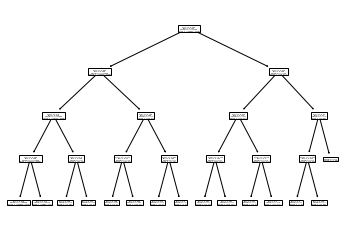

In [33]:
from sklearn import tree
tree.plot_tree(clf)
tree.


### SVM 

In [ ]:
from sklearn.svm import SVC
clf = SVC(gamma='auto').fit(X_train, y_train)

preds_class = clf.predict(X_test)
acc=sum(y_test==preds_class)/len(y_test)
# print(i)
print("accuracy: ",acc)
print("f1: ",f1_score(y_test, preds_class))
print("cm:",confusion_matrix(y_test, preds_class))

print("kaggle: ",sum(clf.predict(kag_del)))

### profiling 

In [ ]:
lo={'recommendation_set_id':str, 'user_id':str, 'session_id':str, 'query_identifier':str,
'query_word_count':float, 'query_char_count':float, 'query_detected_language':str,
'query_document_id':str, 'document_language_provided':str, 'year_published':float,
'number_of_authors':float, 'abstract_word_count':float, 'abstract_char_count':float,
'abstract_detected_language':str, 'first_author_id':str,
'num_pubs_by_first_author':float, 'organization_id':str, 'application_type':str,
'item_type':str, 'request_received':str, 'hour_request_received':str,
'response_delivered':str, 'rec_processing_time':float, 'app_version':str, 'app_lang':str,
'user_os':str, 'user_os_version':str, 'user_java_version':str, 'user_timezone':str,
'country_by_ip':str, 'timezone_by_ip':str, 'local_time_of_request':str,
'local_hour_of_request':str, 'number_of_recs_in_set':float,
'recommendation_algorithm_id_used':str, 'algorithm_class':str, 'cbf_parser':str,
'search_title':str, 'search_keywords':str, 'search_abstract':str,
'time_recs_recieved':str, 'time_recs_displayed':str, 'time_recs_viewed':str,
'clicks':float, 'ctr':float,'set_clicked':float
   }
pars=['request_received', 'response_delivered','local_time_of_request','time_recs_recieved','time_recs_displayed','time_recs_viewed']

df_lo=pd.read_csv('tcdml1920-rec-click-pred--training.csv',na_values=["\\N","nA"],
                 dtype=lo, parse_dates=pars)

In [ ]:
df_lo.shape

In [ ]:
import pandas_profiling
df=df_lo[df_lo.organization_id=='1']
profile = df.profile_report(title='Pandas Profiling Report')
profile.to_file(output_file="output_org1.html")

In [ ]:
df=df_lo[df_lo.organization_id=='4']
profile = df.profile_report(title='Pandas Profiling Report')
profile.to_file(output_file="output_org4.html")

In [ ]:

df=df_lo[df_lo.organization_id=='8']
profile = df.profile_report(title='Pandas Profiling Report')
profile.to_file(output_file="output_org8.html")